In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

Workflow to load in the respective individuals and generate base statistics on them.

In [2]:
# Functions

def read_beds(long_form):
    bed_path_x = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy1.bed".format(long_form, long_form)
    bed_path_all = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy2.bed".format(long_form, long_form)
    bed_l = []
    for b in glob.glob(bed_path_all):
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    bed_files = pd.concat(bed_l)
    bed_l = []
    for b in glob.glob(bed_path_x):
        #print(b)
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    if len(bed_l) > 0:
        bed_x = pd.concat(bed_l)
        bed_files = bed_files.loc[~(bed_files.chrom.isin(bed_x.chrom.unique()))]
        bed_files = pd.concat([bed_files, bed_x]).sort_values(by=["chrom", "start", "end"])
    return bed_files

def pos_windows(bed_l, window_size, chrom_order):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    # It has to be sorted.
    df_l = []
    for c in chrom_order:
        #print(c)
        frac_l = []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_pos, callable_bases = 0, 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Nothing called in the current window under investigation.
            while i-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
            # Window starts in current. We know this is true because of the previous while loop.
            callable_bases += min(k, current_pos+window_size-i)
            # Everything called in current.
            while j-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
                if j-window_size >= current_pos:
                    callable_bases += window_size
                else:
                # Window stops in current. Again, know this is true.
                    callable_bases += j-current_pos
        # Last window.
        frac_l.append(callable_bases/(window_size))
        df_l.append(pd.DataFrame({"chrom": c, "window_start": list(range(0, len(frac_l)*window_size, window_size)),
                                  "window_end": list(range(window_size, (len(frac_l)+1)*window_size, window_size)),
                                  "callable_frac": frac_l}))
    return pd.concat(df_l)

def haploid_double(ds, variable, dim):
    unmasked = ~ds[f"{variable}_mask"]
    overwrite = ds.call_genotype[:,:,0]
    overwrite_2 = ds.call_genotype_mask[:,:,0]
    return ds.assign(**{
        f"{variable}": ds[variable].where(
        unmasked, 
        overwrite),
        f"{variable}_mask": ds[f"{variable}_mask"].where(
        unmasked,
        overwrite_2)})

In [3]:
metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
zarr_path = "../zarr_data/"
metadata_folders = glob.glob(metadata_path+"*_individuals.txt")

size_cutoff = 1000000
window_size = 100000
missing_filter = 0.5

In [4]:
glob.glob("../zarr_data/Macaca_mulatta_ssp/*")

['../zarr_data/Macaca_mulatta_ssp/NC_041759.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041762.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041772.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041768.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041769.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041773.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041763.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041758.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041761.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041771.1',
 '../zarr_data/Macaca_mulatta_ssp/NW_021161850.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041770.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041760.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041764.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041774.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041755.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041754.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041765.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_027914.1',
 '../zarr_data/Macaca_mulatta_ssp/NC_041767.1',
 '../zarr_data/Macaca_mulatta_ssp/NW_

In [37]:

print("Loading metadata")
zarr_path = "../zarr_data/Macaca_mulatta_ssp"
metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"

short_form = zarr_path.split("/")[-1].split("_")[0]
long_form = zarr_path.split("/")[-1]
# Loading the various metadata files. Metadata, contig information, callability bed.
metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]
regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
regions_df["chr_type"] = ["chrX" if x == 2 and y == 1 else "aut" for x, y in zip(regions_df.FEMALE_PLOIDY, regions_df.MALE_PLOIDY)]
large_contigs = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
large_x = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 1)].CONTIG_ID
print("Loading bed files")
bed_files = read_beds(long_form)
# Loading the genetic data.
print("Loading genetic data")
df_l = []
for c in glob.glob(zarr_path+"/*")[:1]:
    ds = sg.load_dataset(c)
    print(c)

Loading metadata
Loading bed files
Loading genetic data
../zarr_data/Macaca_mulatta_ssp/NC_041759.1


In [99]:
large_x

20       CP141341.1
330     NC_041774.1
2996    NC_092145.1
3328    NC_065598.1
Name: CONTIG_ID, dtype: object

In [39]:
ds.variant_position[-1].values

array(179083200, dtype=int32)

In [7]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:               (variants: 5114303, samples: 168, ploidy: 2,
                           contigs: 2924, filters: 2,
                           region_index_values: 5115, region_index_fields: 6,
                           alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/16)
    call_genotype         (variants, samples, ploidy) int8 2GB dask.array<chunksize=(1000, 168, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 2GB dask.array<chunksize=(1000, 168, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 859MB dask.array<chunksize=(1000, 168), meta=np.ndarray>
    contig_id             (contigs) object 23kB dask.array<chunksize=(2924,), meta=np.ndarray>
    contig_length         (contigs) float64 23kB dask.array<chunksize=(2924,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_filter        (variants, filters) bool 10MB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    variant_id            (variants) object 41MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 5MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 10MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 20MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 20MB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

<Axes: ylabel='Count'>

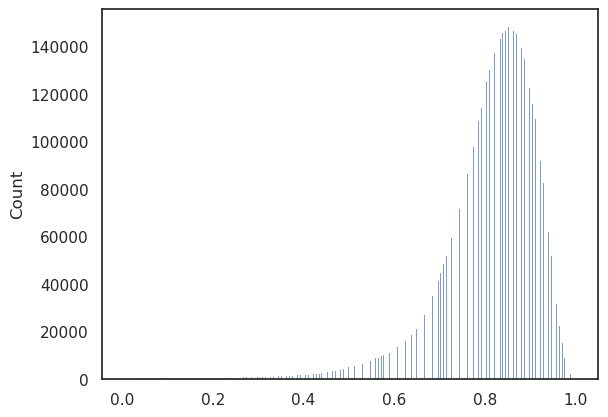

In [89]:
sns.histplot(sg.variant_stats(ds).variant_call_rate.values)

<Axes: ylabel='Count'>

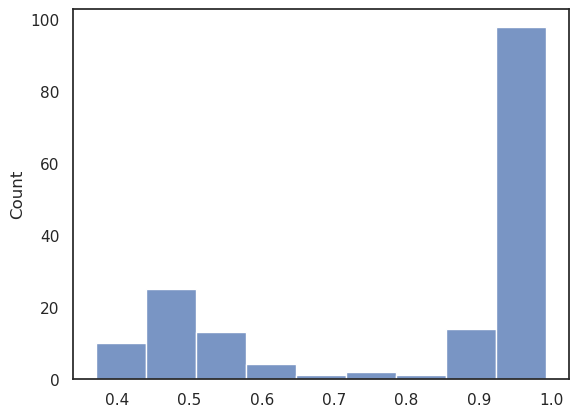

In [91]:
sns.histplot(sg.sample_stats(ds).sample_call_rate.values)

<Axes: ylabel='Count'>

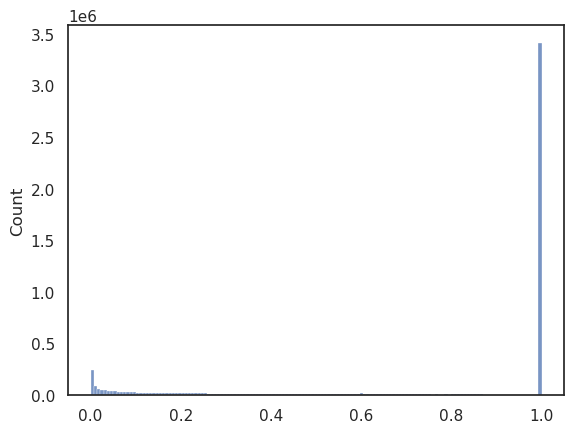

In [90]:
hwe_p = sg.hardy_weinberg_test(ds).variant_hwe_p_value
sns.histplot(hwe_p)

In [94]:
sg.sample_stats(ds.isel(variants=(hwe_p<0.05).compute())).sample_n_het.values

array([ 88009,  78738,  83000,  79398,  79714,  79686,  80319,  88018,
        94433,  89745,  73954,  80469,  69352,  67095,  71921,  72424,
        73518,  53084,  52900,  73520,  73091,  72509,  66695,  69644,
        69207,  64848,  69116,  71642,  70347,  69825,  67841,  68507,
        99959,  68135,  70552,  90736,  96152,  91875,  92049, 112970,
        77497,  90452,  97754,  89858,  82912,  88953,  87578,  90524,
        71276,  72777,  68215,  66427,  83900,  70937,  59677,  81098,
        36083,  42129,  54812,  75074,  52623,  76492,  51578,  53930,
        53096,  78323,  51704,  70712,  40190,  44852,  60033,  48519,
        46757,  49582,  49769,  49813,  41323,  40167,  42917,  52536,
        48680,  66017,  45538,  50708,  43798,  49164,  51934,  55208,
        56037,  58130,  53665,  63966,  53201,  49557,  44078,  50486,
        48186,  43624,  61676,  71941,  54371,  55736,  46575,  75352,
        45752,  82116,  75898,  78881,  72664,  71226,  75859,  62626,
      

In [95]:
sg.sample_stats(ds.isel(variants=(hwe_p>0.05).compute())).sample_n_het.values

array([299090, 265617, 274381, 257299, 278967, 268871, 267520, 287253,
       332835, 292422, 259272, 274801, 400649, 353616, 373554, 408520,
       372214, 314554, 313468, 352096, 394080, 383433, 358047, 368044,
       381624, 359578, 349715, 390618, 402528, 379243, 400573, 403643,
       530915, 400175, 373366, 313937, 307234, 298380, 323310, 407347,
       268572, 294388, 346752, 308333, 276721, 314851, 294905, 306724,
       412430, 409101, 401629, 390423, 284041, 397759, 337834, 272834,
       203268, 236675, 280352, 421407, 284463, 426125, 284160, 299516,
       296290, 423012, 291982, 410317, 218116, 244342, 340439, 258010,
       232261, 267632, 243192, 269055, 220009, 207895, 215499, 271915,
       269276, 390351, 253942, 299363, 243781, 263740, 277458, 303174,
       290807, 316529, 261937, 347906, 290732, 275518, 254937, 291209,
       276311, 252227, 354685, 373116, 168964, 180951, 153708, 235502,
       150631, 402459, 416061, 404339, 386820, 420054, 392434, 388428,
      

In [96]:
sg.sample_stats(ds.isel(variants=(hwe_p<0.05).compute())).sample_n_het.values/sg.sample_stats(ds).sample_n_het.values

array([0.22735528, 0.22865357, 0.23224514, 0.2358144 , 0.22224205,
       0.22861684, 0.23090855, 0.23454517, 0.22101585, 0.23483189,
       0.22193346, 0.22650097, 0.14755713, 0.15948002, 0.16144789,
       0.15058718, 0.16493768, 0.14439204, 0.14439034, 0.17273787,
       0.15645449, 0.15903119, 0.15702474, 0.15911791, 0.15350985,
       0.15278989, 0.16502121, 0.15498204, 0.14876447, 0.1554887 ,
       0.14483128, 0.14509584, 0.15844527, 0.14549123, 0.15893025,
       0.22422054, 0.23836226, 0.23542299, 0.22161311, 0.21711764,
       0.22393511, 0.23503794, 0.21991604, 0.22566557, 0.23054614,
       0.22028757, 0.22897227, 0.2278778 , 0.14735397, 0.15102785,
       0.14518649, 0.14540221, 0.22802569, 0.1513497 , 0.15012666,
       0.22913441, 0.1507535 , 0.15110615, 0.16353785, 0.15121223,
       0.1561115 , 0.15218745, 0.15362574, 0.15258342, 0.15196945,
       0.15622887, 0.15043965, 0.14700153, 0.15559066, 0.15509312,
       0.14990561, 0.15828519, 0.167577  , 0.15630458, 0.16988

<Axes: ylabel='Count'>

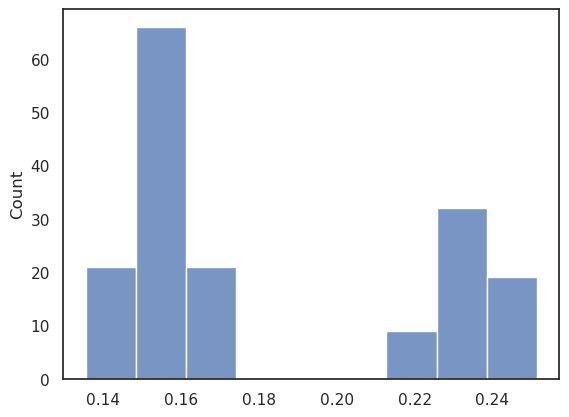

In [97]:
sns.histplot(sg.sample_stats(ds.isel(variants=(hwe_p<0.05).compute())).sample_n_het.values/sg.sample_stats(ds).sample_n_het.values)

<Axes: ylabel='Count'>

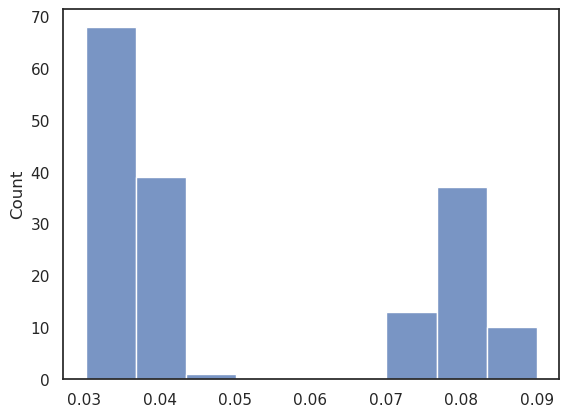

In [98]:
sns.histplot(sg.sample_stats(ds.isel(variants=(hwe_p<0.001).compute())).sample_n_het.values/sg.sample_stats(ds).sample_n_het.values)

<Axes: >

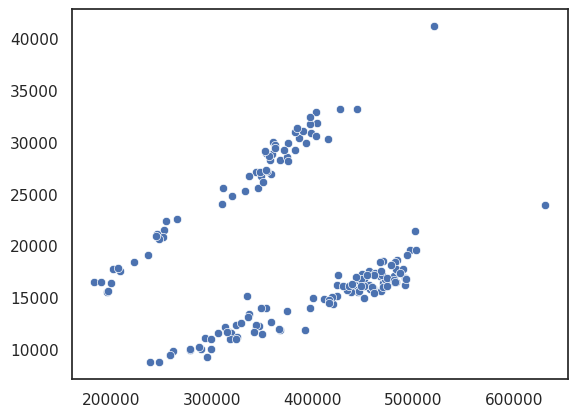

In [102]:
sns.scatterplot(y=sg.sample_stats(ds.isel(variants=(hwe_p<0.001).compute())).sample_n_het.values, x=sg.sample_stats(ds).sample_n_het.values)

<Axes: ylabel='Count'>

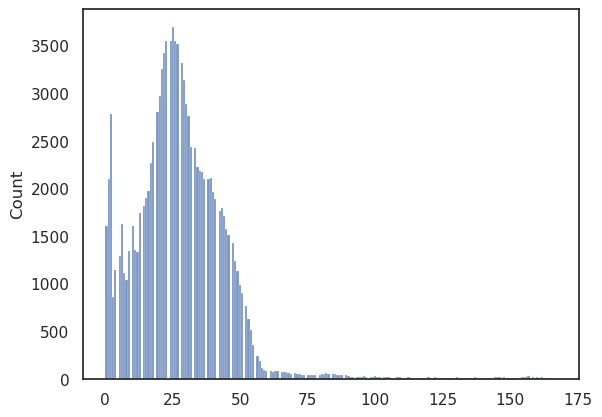

In [103]:
sns.histplot(sg.variant_stats(ds.isel(variants=(hwe_p<0.001).compute())).variant_n_het)

<Axes: ylabel='Count'>

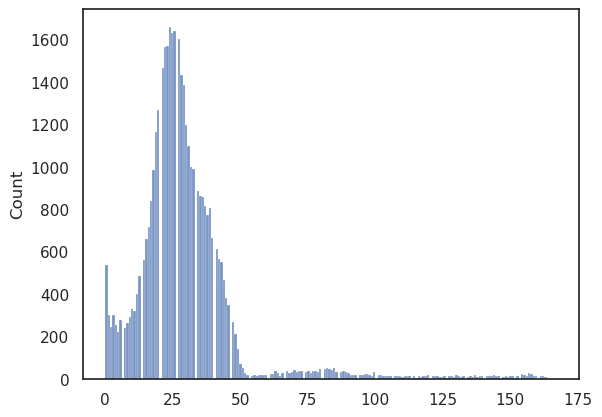

In [105]:
sns.histplot(sg.variant_stats(ds.isel(variants=(hwe_p<0.00001).compute())).variant_n_het)

<Axes: ylabel='Count'>

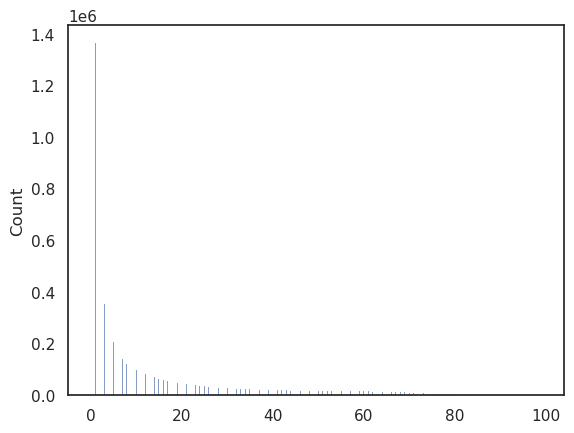

In [104]:
sns.histplot(sg.variant_stats(ds.isel(variants=(hwe_p>0.001).compute())).variant_n_het)

In [41]:
# Fst filtering
maf_filter = 0.1
missing_filter = 0.1
missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=1).values/ds.call_genotype_mask[:,:,0].count(axis=1).values
ds_filt = ds.isel(variants=(missing_rate <= missing_filter))
allele_counts = sg.count_variant_alleles(ds_filt)["variant_allele_count"]
ds_filt = ds_filt.isel(variants=((maf_filter <= (allele_counts[:,1]/allele_counts.sum(axis=1))) &
                                 (1-maf_filter >= (allele_counts[:,1]/allele_counts.sum(axis=1)))).compute())
hwe_p = sg.hardy_weinberg_test(ds_filt).variant_hwe_p_value
ds_filt = ds_filt.isel(variants=(hwe_p >= 0.05).compute())

In [42]:
ds_filt

<xarray.Dataset> Size: 124MB
Dimensions:               (variants: 140336, samples: 168, ploidy: 2,
                           contigs: 2924, filters: 2,
                           region_index_values: 5115, region_index_fields: 6,
                           alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/16)
    call_genotype         (variants, samples, ploidy) int8 47MB dask.array<chunksize=(997, 168, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 47MB dask.array<chunksize=(997, 168, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 24MB dask.array<chunksize=(997, 168), meta=np.ndarray>
    contig_id             (contigs) object 23kB dask.array<chunksize=(2924,), meta=np.ndarray>
    contig_length         (contigs) float64 23kB dask.array<chunksize=(2924,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_filter        (variants, filters) bool 281kB dask.array<chunksize=(997, 2), meta=np.ndarray>
    variant_id            (variants) object 1MB dask.array<chunksize=(997,), meta=np.ndarray>
    variant_id_mask       (variants) bool 140kB dask.array<chunksize=(997,), meta=np.ndarray>
    variant_length        (variants) int16 281kB dask.array<chunksize=(997,), meta=np.ndarray>
    variant_position      (variants) int32 561kB dask.array<chunksize=(997,), meta=np.ndarray>
    variant_quality       (variants) float32 561kB dask.array<chunksize=(997,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [36]:
# hwe sites compared to total, after missing and after maf
((hwe_p < 0.001).sum().compute())/5114303, ((hwe_p < 0.001).sum().compute())/811537, ((hwe_p < 0.001).sum().compute())/201468
# So it ranges from 0.4 % to 10 %

(<xarray.DataArray 'variant_hwe_p_value' ()> Size: 8B
 array(0.00421602),
 <xarray.DataArray 'variant_hwe_p_value' ()> Size: 8B
 array(0.02656934),
 <xarray.DataArray 'variant_hwe_p_value' ()> Size: 8B
 array(0.10702444))

<Axes: ylabel='Count'>

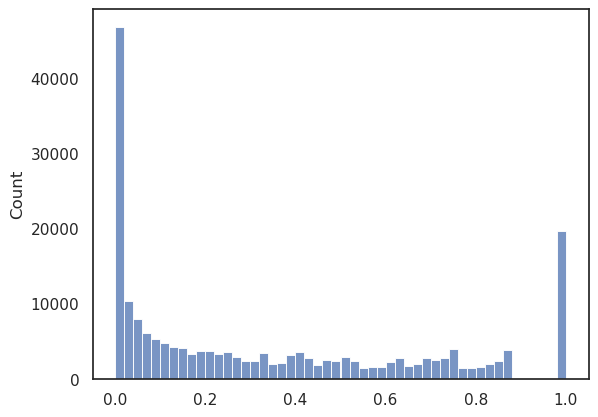

In [28]:
sns.histplot(hwe_p)

<Axes: ylabel='Count'>

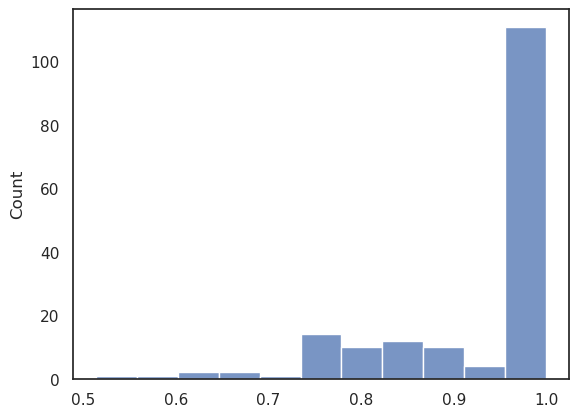

In [86]:
sns.histplot(sg.sample_stats(ds_filt).sample_call_rate.values)

<Axes: ylabel='Count'>

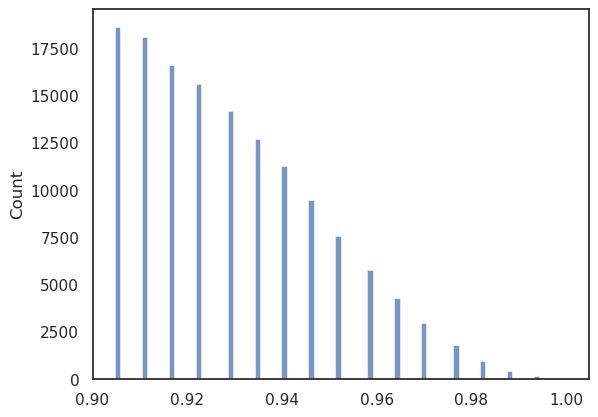

In [88]:
sns.histplot(sg.variant_stats(ds_filt).variant_call_rate.values)

In [80]:
# Greedy clustering.
c_l = [0]
c_l = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2]
for s in range(len(c_l)+1, len(ds.samples)):
    ds_s = ds_filt.isel(samples=ds.samples[:s])
    missing_rate = ds_s.call_genotype_mask[:,:,0].sum(axis=1).values/ds_s.call_genotype_mask[:,:,0].count(axis=1).values
    ds_s = ds_s.isel(variants=(missing_rate <= 0))
    c_l_propose = c_l.copy()
    c_l_propose.append(max(c_l)+1)
    ds_s["sample_cohort"] = (("samples"), c_l_propose)
    ds_s = sg.window_by_genome(ds_s)
    fst_calc = sg.Fst(ds_s)
    # Take the last row and determine if any clusters are close enough (0.05 Fst).
    # Otherwise set it as a new cluster.
    best_fit = 1
    c = 0
    fst_vals = fst_calc.stat_Fst.values
    print(fst_vals)
    vals = fst_vals[0][-1]
    for i in range(len(vals)):
        if vals[i] < best_fit:
            best_fit = vals[i]
            c = i
    print(best_fit, len(ds_s.variants))
    if best_fit < 0.05:
        c_l.append(c)
    else:
        c_l.append(max(c_l)+1)
    print(c_l)

[[[           nan 7.61418039e-02 9.24825299e-02 1.33720851e-01
   1.00217463e-01]
  [7.61418039e-02            nan 1.39869725e-01 1.80686912e-01
   1.47303139e-01]
  [9.24825299e-02 1.39869725e-01            nan 4.00692072e-02
   7.48531879e-05]
  [1.33720851e-01 1.80686912e-01 4.00692072e-02            nan
   5.26065599e-02]
  [1.00217463e-01 1.47303139e-01 7.48531879e-05 5.26065599e-02
              nan]]]
7.485318792010975e-05 78429
[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2]
[[[       nan 0.07611635 0.09287281 0.13380244 0.01390065]
  [0.07611635        nan 0.14031381 0.18092252 0.07622576]
  [0.09287281 0.14031381        nan 0.04074104 0.09532372]
  [0.13380244 0.18092252 0.04074104        nan 0.13455075]
  [0.01390065 0.07622576 0.09532372 0.13455075        nan]]]
0.013900648180268038 77637
[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 

[[[        nan  0.07669752  0.09002932  0.13292393  0.20394529
    0.17857605  0.06122911]
  [ 0.07669752         nan  0.13884117  0.18199136  0.25289307
    0.22828619  0.10770153]
  [ 0.09002932  0.13884117         nan  0.04175101  0.11234238
    0.08652103 -0.02555002]
  [ 0.13292393  0.18199136  0.04175101         nan  0.16033959
    0.13673128  0.02636592]
  [ 0.20394529  0.25289307  0.11234238  0.16033959         nan
    0.18218468  0.09306637]
  [ 0.17857605  0.22828619  0.08652103  0.13673128  0.18218468
           nan  0.06941209]
  [ 0.06122911  0.10770153 -0.02555002  0.02636592  0.09306637
    0.06941209         nan]]]
-0.025550020981981447 14891
[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 4, 5, 2, 2, 2, 2, 2, 2, 2]
[[[        nan  0.07671905  0.0898615   0.13292617  0.20391468
    0.17850309  0.0872087 ]
  [ 0.07671905         nan  0.13863834  0.1820

[[[        nan  0.07786204  0.0911482   0.13407038  0.21990781
    0.18123186  0.1559601   0.17135711  0.09353286]
  [ 0.07786204         nan  0.1402355   0.18715517  0.26965921
    0.23060537  0.20753284  0.22671554  0.14067051]
  [ 0.0911482   0.1402355          nan  0.04217578  0.1292605
    0.08399177  0.06135042  0.07714921 -0.01791263]
  [ 0.13407038  0.18715517  0.04217578         nan  0.18153172
    0.13160891  0.08846768  0.10898406  0.01517993]
  [ 0.21990781  0.26965921  0.1292605   0.18153172         nan
    0.21356579  0.18035779  0.21069959  0.12307283]
  [ 0.18123186  0.23060537  0.08399177  0.13160891  0.21356579
           nan  0.1430796   0.15603036  0.0793224 ]
  [ 0.1559601   0.20753284  0.06135042  0.08846768  0.18035779
    0.1430796          nan  0.14746754  0.0485559 ]
  [ 0.17135711  0.22671554  0.07714921  0.10898406  0.21069959
    0.15603036  0.14746754         nan  0.06311745]
  [ 0.09353286  0.14067051 -0.01791263  0.01517993  0.12307283
    0.0793224   0.

[[[        nan  0.07227202  0.09254173  0.13403242  0.23708556
    0.18065692  0.16903523  0.14677614  0.09710516]
  [ 0.07227202         nan  0.13825832  0.18108328  0.28276658
    0.2232825   0.20667604  0.19465625  0.13236288]
  [ 0.09254173  0.13825832         nan  0.04238748  0.13874731
    0.07429512  0.06948633  0.04549769 -0.01032244]
  [ 0.13403242  0.18108328  0.04238748         nan  0.19430679
    0.12268221  0.09584049  0.08149896  0.02527444]
  [ 0.23708556  0.28276658  0.13874731  0.19430679         nan
    0.21577381  0.19499138  0.18587849  0.10560238]
  [ 0.18065692  0.2232825   0.07429512  0.12268221  0.21577381
           nan  0.14575009  0.11422267  0.05732802]
  [ 0.16903523  0.20667604  0.06948633  0.09584049  0.19499138
    0.14575009         nan  0.11850473  0.04637108]
  [ 0.14677614  0.19465625  0.04549769  0.08149896  0.18587849
    0.11422267  0.11850473         nan -0.01745291]
  [ 0.09710516  0.13236288 -0.01032244  0.02527444  0.10560238
    0.05732802  0

[[[       nan 0.07571079 0.09585911 0.13451778 0.23550766 0.19599031
   0.16705978 0.14322705 0.15226001 0.11087947]
  [0.07571079        nan 0.14376763 0.18576973 0.28131856 0.24879188
   0.21498013 0.19176382 0.20043498 0.1597952 ]
  [0.09585911 0.14376763        nan 0.04152053 0.14223857 0.08008745
   0.07264387 0.0355987  0.0586857  0.00600921]
  [0.13451778 0.18576973 0.04152053        nan 0.19446873 0.12102403
   0.09835377 0.07058117 0.10961727 0.0340821 ]
  [0.23550766 0.28131856 0.14223857 0.19446873        nan 0.22747157
   0.19458347 0.17422503 0.2028597  0.15611814]
  [0.19599031 0.24879188 0.08008745 0.12102403 0.22747157        nan
   0.16990045 0.1101083  0.13220019 0.12372014]
  [0.16705978 0.21498013 0.07264387 0.09835377 0.19458347 0.16990045
          nan 0.10362842 0.14791774 0.08512422]
  [0.14322705 0.19176382 0.0355987  0.07058117 0.17422503 0.1101083
   0.10362842        nan 0.11134266 0.02158486]
  [0.15226001 0.20043498 0.0586857  0.10961727 0.2028597  0.13220

[[[        nan  0.07457365  0.09647277  0.13400692  0.22538837
    0.18838663  0.16729182  0.14457133  0.14743369  0.10125457]
  [ 0.07457365         nan  0.1407454   0.18231649  0.26309271
    0.23838344  0.20979129  0.18757522  0.18841686  0.15466702]
  [ 0.09647277  0.1407454          nan  0.03923009  0.13113379
    0.0677676   0.06988777  0.03543386  0.04763832 -0.00583389]
  [ 0.13400692  0.18231649  0.03923009         nan  0.18122135
    0.10277244  0.09510804  0.0722062   0.09459264  0.02926241]
  [ 0.22538837  0.26309271  0.13113379  0.18122135         nan
    0.21103896  0.18726606  0.16603376  0.17770419  0.08710407]
  [ 0.18838663  0.23838344  0.0677676   0.10277244  0.21103896
           nan  0.15663265  0.10854638  0.10697674  0.06320542]
  [ 0.16729182  0.20979129  0.06988777  0.09510804  0.18726606
    0.15663265         nan  0.10435979  0.13381505  0.06784533]
  [ 0.14457133  0.18757522  0.03543386  0.0722062   0.16603376
    0.10854638  0.10435979         nan  0.103458

[[[       nan 0.07907157 0.09384317 0.13221005 0.22157454 0.19909242
   0.16398345 0.13608232 0.14772039 0.14981086 0.14208908]
  [0.07907157        nan 0.14175836 0.18090504 0.26365348 0.25353419
   0.20512102 0.17819409 0.19207147 0.19791718 0.17218235]
  [0.09384317 0.14175836        nan 0.03672067 0.12596442 0.07299441
   0.06867339 0.02925979 0.03979254 0.04372722 0.03343968]
  [0.13221005 0.18090504 0.03672067        nan 0.17063997 0.10647503
   0.09681736 0.06917419 0.08579731 0.08721355 0.07283223]
  [0.22157454 0.26365348 0.12596442 0.17063997        nan 0.22098569
   0.18158451 0.14930448 0.16045381 0.16017316 0.13793103]
  [0.19909242 0.25353419 0.07299441 0.10647503 0.22098569        nan
   0.16866433 0.10546624 0.10884354 0.10541311 0.03454545]
  [0.16398345 0.20512102 0.06867339 0.09681736 0.18158451 0.16866433
          nan 0.09492871 0.12475656 0.11982621 0.11777448]
  [0.13608232 0.17819409 0.02925979 0.06917419 0.14930448 0.10546624
   0.09492871        nan 0.08639917

[[[        nan  0.07763061  0.07787349  0.12300015  0.07701413
    0.19079807  0.15677024  0.1270519   0.11823938  0.10572317
   -0.12053033]
  [ 0.07763061         nan  0.12759359  0.17030671  0.11286781
    0.19420498  0.21309953  0.1669924   0.16199813  0.13511382
   -0.09727985]
  [ 0.07787349  0.12759359         nan  0.03257285  0.02333667
    0.07401967  0.08213426  0.04785331  0.05188376  0.02435624
   -0.06493737]
  [ 0.12300015  0.17030671  0.03257285         nan  0.07597271
    0.08074279  0.10863903  0.10242784  0.10634893  0.0843699
   -0.03796854]
  [ 0.07701413  0.11286781  0.02333667  0.07597271         nan
    0.14736842  0.07754011  0.00218182  0.08510638  0.03174603
   -0.08737864]
  [ 0.19079807  0.19420498  0.07401967  0.08074279  0.14736842
           nan  0.16666667  0.1210728   0.07792208  0.07831325
    0.01020408]
  [ 0.15677024  0.21309953  0.08213426  0.10863903  0.07754011
    0.16666667         nan  0.12912966  0.19736842  0.14509804
    0.01918465]
  [ 0.1

[[[        nan  0.05810057  0.07674521  0.14359146  0.14038913
    0.24278369  0.18862549  0.10229994  0.05546151  0.03873903
    0.07894596  0.15652278]
  [ 0.05810057         nan  0.12840781  0.18444529  0.17069039
    0.22563353  0.22819724  0.14978355  0.10528869  0.06982779
    0.14404919  0.17377778]
  [ 0.07674521  0.12840781         nan  0.04639575  0.05531005
    0.10503879  0.10410978  0.02927541  0.06788189 -0.03636939
    0.20785352  0.05507221]
  [ 0.14359146  0.18444529  0.04639575         nan  0.044212
    0.16281496  0.1225173   0.09549425  0.1516554   0.06600918
    0.25511138  0.02812793]
  [ 0.14038913  0.17069039  0.05531005  0.044212           nan
    0.15813953  0.02767857  0.01280788  0.17368421  0.0352518
    0.23352601  0.03358779]
  [ 0.24278369  0.22563353  0.10503879  0.16281496  0.15813953
           nan  0.23918367  0.128       0.18875502  0.07594937
    0.37931034  0.22727273]
  [ 0.18862549  0.22819724  0.10410978  0.1225173   0.02767857
    0.23918367  

[[[        nan  0.05810057  0.07674521  0.14529872  0.14038913
    0.24278369  0.18862549  0.11734683  0.05546151  0.05033686
    0.07894596  0.19947444  0.24613115]
  [ 0.05810057         nan  0.12840781  0.18632541  0.17069039
    0.22563353  0.22819724  0.15706505  0.10528869  0.078487
    0.14404919  0.25264047  0.25675077]
  [ 0.07674521  0.12840781         nan  0.0475533   0.05531005
    0.10503879  0.10410978  0.03712226  0.06788189 -0.02236012
    0.20785352  0.10172329  0.15995109]
  [ 0.14529872  0.18632541  0.0475533          nan  0.04507861
    0.16435598  0.12449583  0.08278754  0.15184567  0.07427405
    0.25454363  0.08653282  0.15492649]
  [ 0.14038913  0.17069039  0.05531005  0.04507861         nan
    0.15813953  0.02767857  0.01947326  0.17368421  0.05059666
    0.23352601  0.14468085  0.02051282]
  [ 0.24278369  0.22563353  0.10503879  0.16435598  0.15813953
           nan  0.23918367  0.15553677  0.18875502  0.08474576
    0.37931034  0.27272727  0.31818182]
  [ 0.

KeyboardInterrupt: 

In [77]:
ds_s.call_genotype_mask[:,:,0].sum(axis=1).values/ds_s.call_genotype_mask[:,:,0].count(axis=1).values

array([0.02083333, 0.        , 0.0625    , ..., 0.        , 0.        ,
       0.04166667])

In [158]:
fst_vals = fst_calc.stat_Fst.values

In [68]:
from sgkit.cohorts import _cohorts_to_array
from sgkit.stats.utils import assert_array_shape
from sgkit.utils import (
    conditional_merge_datasets,
    create_dataset,
    define_variable_if_absent,
)
from sgkit.window import has_windows, window_statistic

from sgkit import variables
from sgkit.stats.aggregation import (
    count_cohort_alleles,
    count_variant_alleles,
    individual_heterozygosity,
)

In [69]:
def alt_hom(ds):
    # Computes alt hom per individual in windows.
    alt_hom = ((ds.call_genotype[:,:,0] == ds.call_genotype[:,:,1]) & (ds.call_genotype[:,:,0] >= 1))
    w_hom = window_statistic(
            alt_hom,
            np.sum,
            ds.window_start.values,
            ds.window_stop.values,
            dtype=np.int64,
            axis=0,
    )
    return w_hom

In [70]:
ds["sample_cohort"] = ds["samples"]
ds = ds.sel(contigs=[ds.variant_contig[0].values])
ds = ds.chunk({"variants": 10000})
ds = sg.window_by_position(ds, size=100000)

In [71]:
ds["alt_hom"] = (("windows", "cohorts"), alt_hom(ds))

In [74]:
np.corrcoef(ds.alt_hom, rowvar=False)

array([[1.        , 0.25403211, 0.26724071, ..., 0.24492396, 0.20911192,
        0.30321996],
       [0.25403211, 1.        , 0.38964108, ..., 0.26109662, 0.22847214,
        0.26266924],
       [0.26724071, 0.38964108, 1.        , ..., 0.34604382, 0.24875452,
        0.28725596],
       ...,
       [0.24492396, 0.26109662, 0.34604382, ..., 1.        , 0.34985797,
        0.35395546],
       [0.20911192, 0.22847214, 0.24875452, ..., 0.34985797, 1.        ,
        0.30222771],
       [0.30321996, 0.26266924, 0.28725596, ..., 0.35395546, 0.30222771,
        1.        ]])

In [13]:
#Count alt hom
((ds.call_genotype[:,:,0] == ds.call_genotype[:,:,1]) & (ds.call_genotype[:,:,0] >= 1)).sum(axis=1)[:10].values

array([0, 0, 0, 2, 5, 2, 0, 0, 0, 0])

In [14]:
#Count ref hom
((ds.call_genotype[:,:,0] == ds.call_genotype[:,:,1]) & (ds.call_genotype[:,:,0] == 0)).sum(axis=1)[:10].values

array([2, 2, 2, 0, 0, 0, 6, 3, 3, 5])

In [22]:
#Count all hom
((ds.call_genotype[:,:,0] == ds.call_genotype[:,:,1]) & (ds.call_genotype[:,:,0] >= 0)).sum(axis=1)[:20].values

array([2, 2, 2, 2, 5, 2, 6, 3, 3, 5, 5, 3, 0, 0, 0, 1, 2, 0, 2, 6])

In [31]:
define_variable_if_absent

<function sgkit.utils.define_variable_if_absent(ds: xarray.core.dataset.Dataset, default_variable_name: Hashable, variable_name: Optional[Hashable], func: Callable[[xarray.core.dataset.Dataset], xarray.core.dataset.Dataset], **kwargs) -> xarray.core.dataset.Dataset>

In [ ]:
# Fst implementation.
for x in glob.glob(zarr_path+"*")[25:]:
    # The name used to load all the files, short and long version
    short_form = x.split("/")[-1].split("_")[0]
    long_form = x.split("/")[-1]
    # Loading the various metadata files. Metadata, contig information, callability bed.
    metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
    metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
    metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]
    regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
    regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
    regions_df["chr_type"] = ["ChrX" if x == 2 and y == 1 else "ChrY" if x == 0 and y == 1 else "Aut" for x, y in zip(regions_df.FEMALE_PLOIDY, regions_df.MALE_PLOIDY)]
    large_contigs = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
    large_x = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 1)].CONTIG_ID
    # Skipping the large samples sizes and the singulars for the first Fst calc
    # Also perform a 10X filter to get accurate samples sizes
    sample_size = len(metadata_df.loc[(metadata_df.GVCF_FOLDER == long_form) &
                                     (metadata_df.AVG_COVERAGE_A >= 10)])
    print(sample_size, long_form)
    if (sample_size > 20) or (sample_size <= 1):
        print("Skipping, sample size", sample_size)
        continue
    if os.path.exists("../results/window_stats/{}_Fst.txt".format(long_form)):
        print("Skipping as it's processed")
        continue
    if len(glob.glob(x+"/*")) == 0:
        print("Skipping, no completed zarrs")
        continue
    # Loading the genetic data.
    df_l = []
    for c in glob.glob(x+"/*"):
        print(c)
        ds = sg.load_dataset(c)
        # This implementation is the pi implementation.
        # Probably problematic in some cases with population structure, but it is easier to implement
        ds["sample_cohort"] = ds["samples"]
        # Subsetting and windowing the sgkit dataset. The rechunking handles what otherwise would cause an error.
        #ds["call_genotype"] = ds["call_genotype"].clip(0)
        ds = ds.sel(contigs=[ds.variant_contig[0].values])
        if c.split("/")[-1] in list(large_x):
            ds = haploid_double(ds, "call_genotype", "samples")
        missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=1).values/ds.call_genotype_mask[:,:,0].count(axis=1).values
        ds = ds.isel(variants=(missing_rate <= 0))
        ds = sg.window_by_genome(ds)
        ds = (sg.Fst(ds.chunk({"variants": 10000})))
        df_sub = pd.DataFrame(ds.stat_Fst[0,:,], columns=ds.sample_id)
        df_sub["chrom"] = c.split("/")[-1]
        df_sub["variants_used"] = len(ds.variants)
        df_sub["stat"] = "Fst"
        df_l.append(df_sub)
        df_sub = pd.DataFrame(ds.stat_divergence[0,:,], columns=ds.sample_id)
        df_sub["chrom"] = c.split("/")[-1]
        df_sub["variants_used"] = len(ds.variants)
        df_sub["stat"] = "Divergence"
        df_l.append(df_sub)
    output_df = pd.concat(df_l)
    output_df["chr_type"] = output_df["chrom"].map(dict(zip(regions_df.CONTIG_ID, regions_df.chr_type)))
    output_df["species"] = long_form
    output_df.to_csv("../results/window_stats/{}_Fst.txt".format(long_form), sep="\t")

2 Avahi_laniger_ssp
../zarr_data/Avahi_laniger_ssp/HiC_scaffold_2
../zarr_data/Avahi_laniger_ssp/HiC_scaffold_1
1 Lepilemur_sahamalazensis_ssp
Skipping, sample size 1
3 Allenopithecus_nigroviridis_ssp
../zarr_data/Allenopithecus_nigroviridis_ssp/HiC_scaffold_1
../zarr_data/Allenopithecus_nigroviridis_ssp/HiC_scaffold_2
3 Alouatta_belzebul_ssp
../zarr_data/Alouatta_belzebul_ssp/CAJZLT010000017.1
../zarr_data/Alouatta_belzebul_ssp/CAJZLT010000080.1
../zarr_data/Alouatta_belzebul_ssp/CAJZLT010000046.1
../zarr_data/Alouatta_belzebul_ssp/CAJZLT010000034.1
../zarr_data/Alouatta_belzebul_ssp/CAJZLT010000072.1
../zarr_data/Alouatta_belzebul_ssp/CAJZLT010000001.1
../zarr_data/Alouatta_belzebul_ssp/CAJZLT010000040.1
../zarr_data/Alouatta_belzebul_ssp/CAJZLT010000060.1
2 Cercopithecus_denti_ssp
../zarr_data/Cercopithecus_denti_ssp/CM053398.1
../zarr_data/Cercopithecus_denti_ssp/CM053363.1
10 Saimiri_ustus_ssp
../zarr_data/Saimiri_ustus_ssp/NW_024100917.1
../zarr_data/Saimiri_ustus_ssp/NW_02410092

../zarr_data/Alouatta_juara_ssp/CAJZLT010000072.1
../zarr_data/Alouatta_juara_ssp/CAJZLT010000040.1
../zarr_data/Alouatta_juara_ssp/CAJZLT010000060.1
../zarr_data/Alouatta_juara_ssp/CAJZLT010000017.1
../zarr_data/Alouatta_juara_ssp/CAJZLT010000046.1
../zarr_data/Alouatta_juara_ssp/CAJZLT010000080.1
../zarr_data/Alouatta_juara_ssp/CAJZLT010000034.1
1 Hylobates_klossii_ssp
Skipping, sample size 1
4 Cheracebus_lucifer_ssp
../zarr_data/Cheracebus_lucifer_ssp/CM080837.1
../zarr_data/Cheracebus_lucifer_ssp/CM080815.1
1 Propithecus_deckenii_ssp
Skipping, sample size 1
2 Cheracebus_regulus_ssp
../zarr_data/Cheracebus_regulus_ssp/CM080815.1
../zarr_data/Cheracebus_regulus_ssp/CM080837.1
2 Alouatta_palliata_ssp
../zarr_data/Alouatta_palliata_ssp/CAJZLT010000017.1
../zarr_data/Alouatta_palliata_ssp/CAJZLT010000034.1
../zarr_data/Alouatta_palliata_ssp/CAJZLT010000046.1
../zarr_data/Alouatta_palliata_ssp/CAJZLT010000080.1
../zarr_data/Alouatta_palliata_ssp/CAJZLT010000001.1
../zarr_data/Alouatta_pa

../zarr_data/Papio_papio_ssp/NC_044976.1
3 Galago_senegalensis_ssp
../zarr_data/Galago_senegalensis_ssp/HiC_scaffold_1
../zarr_data/Galago_senegalensis_ssp/HiC_scaffold_31
2 Ateles_paniscus_ssp
../zarr_data/Ateles_paniscus_ssp/CAJZLT010000040.1
../zarr_data/Ateles_paniscus_ssp/CAJZLT010000060.1
../zarr_data/Ateles_paniscus_ssp/CAJZLT010000072.1
../zarr_data/Ateles_paniscus_ssp/CAJZLT010000001.1
../zarr_data/Ateles_paniscus_ssp/CAJZLT010000080.1
../zarr_data/Ateles_paniscus_ssp/CAJZLT010000046.1
../zarr_data/Ateles_paniscus_ssp/CAJZLT010000034.1
../zarr_data/Ateles_paniscus_ssp/CAJZLT010000017.1
5 Varecia_variegata_ssp
../zarr_data/Varecia_variegata_ssp/CM052457.1
../zarr_data/Varecia_variegata_ssp/CM052436.1
1 Cercocebus_lunulatus_ssp
Skipping, sample size 1
1 Macaca_siberu_ssp
Skipping, sample size 1
2 Xanthonycticebus_pygmaeus_ssp
../zarr_data/Xanthonycticebus_pygmaeus_ssp/NC_069780.1
../zarr_data/Xanthonycticebus_pygmaeus_ssp/NC_069804.1
../zarr_data/Xanthonycticebus_pygmaeus_ssp/NC

../zarr_data/Macaca_leonina_ssp/NC_092145.1
../zarr_data/Macaca_leonina_ssp/NC_092146.1
../zarr_data/Macaca_leonina_ssp/NC_092125.1
7 Pygathrix_nemaeus_ssp
../zarr_data/Pygathrix_nemaeus_ssp/NC_044549.1
../zarr_data/Pygathrix_nemaeus_ssp/NC_044555.1
3 Otolemur_crassicaudatus_ssp
../zarr_data/Otolemur_crassicaudatus_ssp/HiC_scaffold_1
3 Cercopithecus_cephus_ssp
../zarr_data/Cercopithecus_cephus_ssp/CM053398.1
../zarr_data/Cercopithecus_cephus_ssp/CM053363.1
2 Loris_lydekkerianus_ssp
../zarr_data/Loris_lydekkerianus_ssp/NC_069805.1
../zarr_data/Loris_lydekkerianus_ssp/NC_069804.1
../zarr_data/Loris_lydekkerianus_ssp/NC_069780.1
80 Papio_cynocephalus_ssp
Skipping, sample size 80
1 Carlito_syrichta_ssp
Skipping, sample size 1
21 Alouatta_seniculus_ssp
Skipping, sample size 21
13 Cercocebus_atys_ssp
../zarr_data/Cercocebus_atys_ssp/HiC_scaffold_21
../zarr_data/Cercocebus_atys_ssp/HiC_scaffold_111
../zarr_data/Cercocebus_atys_ssp/HiC_scaffold_1
17 Pan_paniscus_ssp
../zarr_data/Pan_paniscus_s

In [27]:
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [46]:
def divergence_divide(square_df):
    square_out = np.zeros((len(square_df), len(square_df)))
    for i in range(len(square_df)):
        for j in range(len(square_df)):
            square_out[i,j] = square_df.iloc[i,j]/((square_df.iloc[i,i]+square_df.iloc[j,j])/2)
    return square_out

Flexible intervals:

In [ ]:
def interval_creator(bed_l, window_size):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    df_l = []
    for c in bed_l.chrom.unique():
        print(c)
        start_l, end_l = [], []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_size = 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Current window encapsulates the final stretch of the interval.
            if current_size + k >= window_size:
                start_l.append(w_start), end_l.append(i+(window_size-current_size))
                w_start = i+(window_size-current_size)
                # If the window still contains full intervals, contigous windows until it cant.
                for x in range((k-window_size+current_size)//window_size):
                    start_l.append(w_start), end_l.append(w_start+window_size)
                    w_start += window_size
                current_size = j-w_start
            # Current window does not encapsulate per definition, so it has to be added to current size but nothing else.
            else:
                current_size += k
        df_l.append(pd.DataFrame({"chrom": c, "interval_start": start_l, "interval_end": end_l}))
    return pd.concat(df_l)